## Self study 5

In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In this self study we work with the small movie rating dataset 'MovieLens 100k'.
The original source can be found at https://grouplens.org/datasets/movielens/100k/

We will only use two data files:

u.data: from the README:

100000 ratings by 943 users on 1682 items. Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. This is a tab separated list of user id | item id | rating | timestamp. The time stamps are unix seconds since 1/1/1970 UTC  


u_comma.item: this is a slightly re-formatted (now comma separated) version of u.item in the original source. From the README:

Information about the items (movies); this is a tab separated list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.




We can first read the rating data into a numpy array. 

In [23]:
R=np.genfromtxt('u.data',dtype=int)
print(R[1:20,:])

[[      186       302         3 891717742]
 [       22       377         1 878887116]
 [      244        51         2 880606923]
 [      166       346         1 886397596]
 [      298       474         4 884182806]
 [      115       265         2 881171488]
 [      253       465         5 891628467]
 [      305       451         3 886324817]
 [        6        86         3 883603013]
 [       62       257         2 879372434]
 [      286      1014         5 879781125]
 [      200       222         5 876042340]
 [      210        40         3 891035994]
 [      224        29         3 888104457]
 [      303       785         3 879485318]
 [      122       387         5 879270459]
 [      194       274         2 879539794]
 [      291      1042         4 874834944]
 [      234      1184         2 892079237]]


The movie features go into a Pandas dataframe. Be aware that movie identifiers start at 1, and therefore are 1+ the row index in the dataframe.

In [3]:
Mf=pd.read_csv('u_comma.item',sep=',')

display(Mf)

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


It is useful to transform the 'release date' column into the datetime datatype:

In [4]:
Mf['release date']=pd.to_datetime(Mf['release date'])

One can now get the time difference between two release dates (e.g. in days):

In [5]:
(Mf.iloc[2,2]-Mf.iloc[12,2]).days

-302

To get an overview of the ratings of different users, we can collect the number of each user's ratings in one array. Note that here, too, there is a difference of 1 between user identifier, and index in the array:

In [7]:
Nratings=np.zeros(943)
for i in range(943):
    Nratings[i]=len(np.where(R[:,0]==i+1)[0])

We get an overview of the distribution of the number of ratings:

The minimal number of ratings is 20.0; the maximal number is 737.0
Distribution:


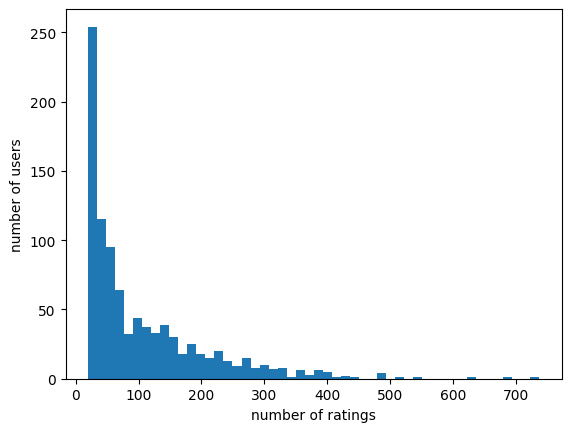

In [8]:
print("The minimal number of ratings is {}; the maximal number is {}".format(np.min(Nratings),np.max(Nratings)))
print("Distribution:")
plt.hist(Nratings,bins=50)
plt.xlabel("number of ratings")
plt.ylabel("number of users")

plt.show()

**Task 1:** Select one user with a relatively large number of ratings. Split the data for this user into a training and a test set, and use the traing movies to build a content based prediction model that predicts this user's ratings for the movies in the test set. Evaluate using the RMSE measure. We only have the genre features, and perhaps the release date, as potentially informative features, so we cannot expect a tremendously high accuracy...

For completing this task, you can either make an implementation from scratch or you can rely on one of the existing making learning toolboxes, like <a href="https://scikit-learn.org/stable/">sci-kit learn</a>.


In [187]:
#Select one user with a relatively large number of ratings. 
maxVal = np.max(Nratings)
idx = np.argmax(Nratings)
print("id:", idx)
    
users = [] #[[USER ID, ITEM ID, RATING, TIMESTAMP],...]
userids = R[:, 0]
def getRows(R):
    for i in range(0,len(R)):
        if R[i][0] == 404:
            users.append(R[i].tolist())
            
getRows(R)

df = pd.DataFrame(users, columns=['user id','item id', 'rating', 'timestamp'])
Mf=pd.read_csv('u_comma.item',sep=',')


df.rename(columns={'item id': 'movie id'},
          inplace=True, errors='raise')

merged_df = pd.merge(df, Mf, on='movie id')


x = merged_df.drop(['rating', 'movie title', 'release date', 'video release date', 'IMDb URL'], axis=1)
y = merged_df['rating']

display(x)

#Split the data for this user into a training and a test set, 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#and use the training movies to build a content based prediction model that 
# predicts this user's ratings for the movies in the test set.
#Evaluate using the RMSE measure. We only have the genre features, and perhaps 
# the release date, as potentially informative features, so we cannot expect a 
# tremendously high accuracy...

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
rmse_accuracy = math.sqrt(mean_squared_error(y_test, y_pred))
print("Accuracy:", accuracy)
print("RMSE:", rmse_accuracy)





id: 404


,user id,movie id,timestamp,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,404,687,883790465,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,404,333,883790286,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,404,269,883790750,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,404,327,883790366,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,404,748,883790430,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5,404,892,883790550,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
6,404,294,883790430,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,404,313,883790181,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,404,328,883790749,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
9,404,342,883790750,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Accuracy: 0.4444444444444444
RMSE: 1.4529663145135578


**Task 2:** For the same user, and the same train/test split, implement the user-based neighborhood method. How does the RMSE compare to what you got in the content-based approach?

Note: for the next lecture we will continue with different recommendation techniques for this dataset. If today you run out of time before completing Task 2, just postpone until next time when there should be a bit of extra time to finish this task.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
